In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

MAX_REWARD = 2.0

In [50]:
rewardEmptyReconfiguration_df = pd.read_csv("C:\\tmp\\SIMEXP\\reward_emptyReconfiguration.csv")
metricsEmptyReconfiguration_df = pd.read_csv("C:\\tmp\\SIMEXP\\metrics_emptyReconfiguration.csv")

rewardScaling_df = pd.read_csv("C:\\tmp\\SIMEXP\\reward_scaling.csv")
metricsScaling_df = pd.read_csv("C:\\tmp\\SIMEXP\\metrics_scaling.csv")

rewardScalingWNR_df = pd.read_csv("C:\\tmp\\SIMEXP\\reward_scalingWithNodeRecovery.csv")
metricsScalingWNR_df = pd.read_csv("C:\\tmp\\SIMEXP\\metrics_scalingWithNodeRecovery.csv")

In [51]:
def findResponseTime(sampleHash, metrics_df):
    for metricRow in metrics_df.index:
        metricId = metrics_df["id"][metricRow]
        if sampleHash == metricId:
            responseTime = metrics_df["responsetime"][metricRow]
            return responseTime
    raise RuntimeError("metric id not found: %s" % sampleHash)

In [52]:
def findSuccessRate(sampleHash, metrics_df):
    for metricRow in metrics_df.index:
        metricId = metrics_df["id"][metricRow]
        if sampleHash == metricId:
            responseTime = metrics_df["successrate"][metricRow]
            return responseTime
    raise RuntimeError("metric id not found: %s" % sampleHash)

In [53]:
def calculateAccumulatedReward(reward_df, metrics_df, strategyLabel):
    entries_df = pd.DataFrame({
        'Time': pd.Series(dtype='int'), 
        'Reward': pd.Series(dtype='float'),
        'Accumulated reward ratio': pd.Series(dtype='float'),
        'Response time': pd.Series(dtype='float'),
        'Success rate': pd.Series(dtype='float'),
        'Strategy': pd.Series(dtype='string'),
    })
    times = []
    rewards = []
    accumulatedRewards = []
    responseTimes = []
    successRates = []
    accumulatedReward = 0
    count = 1
    strategyLabels = []
    for row in reward_df.index:
        counter = 0
        columnCount = len(reward_df.columns) // 2
        for tupleIndex in range(columnCount):
            idColumn = "id%s" % tupleIndex
            rewardColumn = "reward%s" % tupleIndex
                
            sampleHash = reward_df[idColumn][row]
            responseTime = findResponseTime(sampleHash, metrics_df)
            responseTimes.append(responseTime)
            successRate = findSuccessRate(sampleHash, metrics_df)
            successRates.append(successRate)
           
            reward = reward_df[rewardColumn][row]
            rewards.append(reward)
            accumulatedReward += reward
            currentMaximumReward = (count * MAX_REWARD)
            currentRatio = accumulatedReward / currentMaximumReward
            times.append(counter)
            accumulatedRewards.append(currentRatio)
            counter += 1
            count += 1
    strategyLabels = [strategyLabel] * len(times)
    newEntries_df = pd.DataFrame({
        'Time': times, 
        'Reward': rewards,
        'Accumulated reward ratio' : accumulatedRewards, 
        'Response time': responseTimes,
        'Success rate': successRates,
        'Strategy': strategyLabels,
    })
    entryCount = count - 1
    totalMaximumReward = entryCount * MAX_REWARD
    totalRewardRatio = accumulatedReward / totalMaximumReward
    entries_df = entries_df.append(newEntries_df, ignore_index=True)
    return accumulatedReward, totalRewardRatio, entries_df

In [54]:
ercAccumulatedReward, ercTotalRewardRatio, ercEntries_df = calculateAccumulatedReward(rewardEmptyReconfiguration_df, metricsEmptyReconfiguration_df, "Empty reconfiguration")
scalingAccumulatedReward, scalingTotalRewardRatio, scalingEntries_df = calculateAccumulatedReward(rewardScaling_df, metricsScaling_df, "Scaling")
scalingWNRAccumulatedReward, scalingWNRTotalRewardRatio, scalingWNREntries_df = calculateAccumulatedReward(rewardScalingWNR_df, metricsScalingWNR_df, "Scaling with node recovery")
#print(entries_df.dtypes)

In [8]:
print("Total reward erc:        %s" % ercAccumulatedReward)
print("Total reward scaling:    %s" % scalingAccumulatedReward)
print("Total reward scalingWNR: %s" % scalingWNRAccumulatedReward)

Total reward erc:        5281.333333333274
Total reward scaling:    5508.600903729875
Total reward scalingWNR: 5888.68222038906


In [9]:
print("Total reward ratio erc:        %s" % ercTotalRewardRatio)
print("Total reward ratio scaling:    %s" % scalingTotalRewardRatio)
print("Total reward ratio scalingWNR: %s" % scalingWNRTotalRewardRatio)

Total reward ratio erc:        0.5334680134680074
Total reward ratio scaling:    0.5564243337100885
Total reward ratio scalingWNR: 0.5948163858978848


In [41]:
def printMeanInfo(df, strategy):
    print("Strategy: %s" % strategy)
    mean = df["Success rate"].mean()
    print(df["Success rate"].value_counts())
    print("mean: %s" % mean)
    print()

In [42]:
printMeanInfo(ercEntries_df, "erc")
printMeanInfo(scalingEntries_df, "scaling")
printMeanInfo(scalingWNREntries_df, "scalingWNR")

Strategy: erc
1.0    4409
0.0     541
Name: Success rate, dtype: int64
mean: 0.8907070707070707

Strategy: scaling
1.000000    3861
0.000000     342
0.436000      73
0.424000      55
0.489022      34
            ... 
0.884444       1
0.172000       1
0.178000       1
0.098000       1
0.782000       1
Name: Success rate, Length: 94, dtype: int64
mean: 0.8544792464152922

Strategy: scalingWNR
1.00000    4026
0.00000      72
0.50800      42
0.50200      25
0.52400      24
           ... 
0.64200       1
0.41400       1
0.10400       1
0.34000       1
0.51992       1
Name: Success rate, Length: 202, dtype: int64
mean: 0.8989061631955281



In [55]:
def showStrategy(df, palette, meanColor):
    f, axs = plt.subplots(1, 3, figsize=(12, 4))#, gridspec_kw=dict(width_ratios=[4, 3]))
    sns.lineplot(data=df, x="Time", y="Accumulated reward ratio", hue="Strategy", palette=palette, ax=axs[0])
    axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', borderaxespad=0.)
    sns.lineplot(data=df, x="Time", y="Response time", hue="Strategy", palette=palette, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', borderaxespad=0.)
    
    mean = df["Success rate"].mean()
    axes = sns.scatterplot(data=df, x="Time", y="Success rate", hue="Strategy", palette=palette, ax=axs[2])
    axes.axhline(mean, linestyle='--', color=meanColor, label="Success rate mean")
    handles, labels = axes.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    axs[2].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', borderaxespad=0., handles=handles, labels=labels)
    
    f.tight_layout()

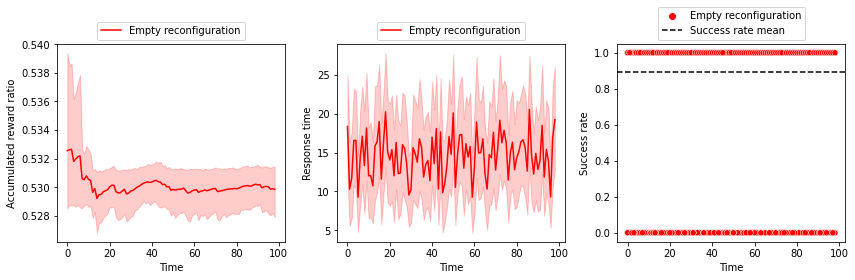

In [56]:
showStrategy(ercEntries_df, ['red'], "black")

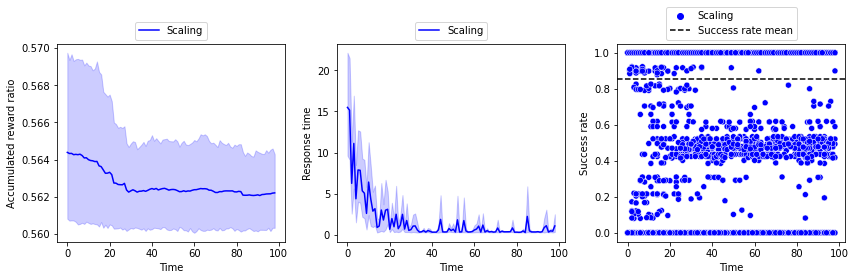

In [57]:
showStrategy(scalingEntries_df, ['blue'], "black")

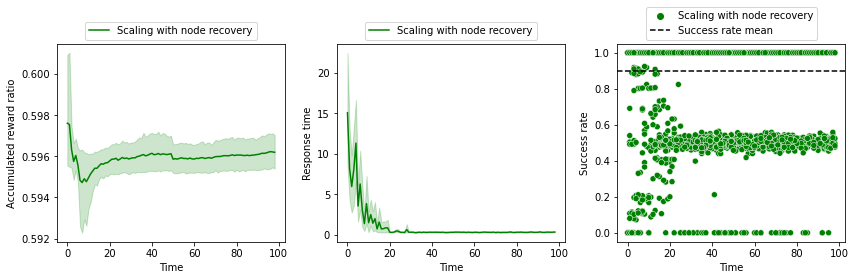

In [58]:
showStrategy(scalingWNREntries_df, ['green'], "black")

In [59]:
combined_df = pd.concat([ercEntries_df, scalingEntries_df, scalingWNREntries_df])

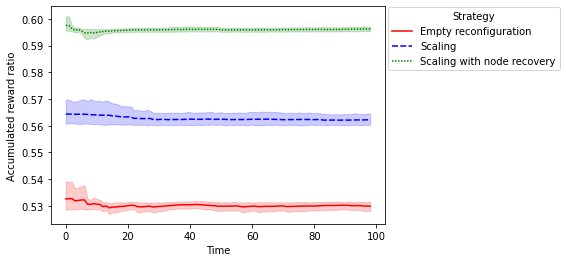

In [60]:
sns.lineplot(data=combined_df, x="Time", y="Accumulated reward ratio", hue="Strategy", style='Strategy', palette=['red', 'blue', 'green'])
plt.legend(bbox_to_anchor=(1., 1., 1., .01), loc='upper left', borderaxespad=0.3, title="Strategy")

In [61]:
def buildTotalRewardRatio(df):
    times_df = pd.DataFrame({
        'AbsTime': pd.Series(dtype='int'), 
        'Accumulated reward ratio': pd.Series(dtype='float'),
        'Strategy': pd.Series(dtype='string'),
        })
    absTime = 0
    absTimes = []
    accumulatedRewards = []
    strategies = []
    for row in df.index:
        accRewardRatio = df["Accumulated reward ratio"][row]
        strategies.append(df["Strategy"][row])
        accumulatedRewards.append(accRewardRatio)
        absTimes.append(absTime)
        absTime += 1

    newEntries_df = pd.DataFrame({
        'AbsTime': absTimes, 
        'Accumulated reward ratio' : accumulatedRewards, 
        'Strategy': strategies,
    })
    times_df = times_df.append(newEntries_df, ignore_index=True)
    return times_df

In [62]:
ercTimes_df = buildTotalRewardRatio(ercEntries_df)
scalingTimes_df = buildTotalRewardRatio(scalingEntries_df)
scalingWNRTimes_df = buildTotalRewardRatio(scalingWNREntries_df)
combinedTimes_df = pd.concat([ercTimes_df, scalingTimes_df, scalingWNRTimes_df])

<AxesSubplot:xlabel='AbsTime', ylabel='Accumulated reward ratio'>

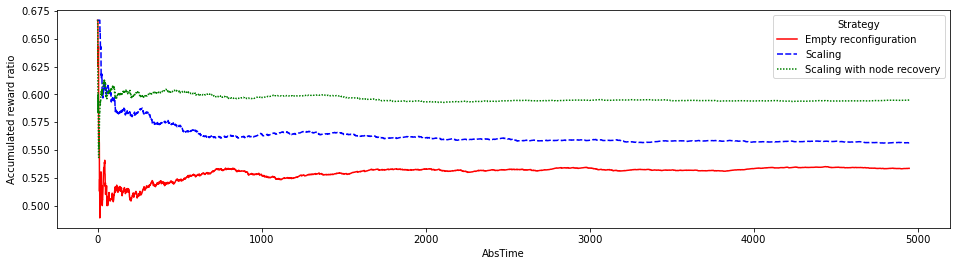

In [63]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(data=combinedTimes_df, x="AbsTime", y="Accumulated reward ratio", hue="Strategy", style='Strategy', palette=['red', 'blue', 'green'], ax=ax)